**Tarea 4**

Gradiente descendiente

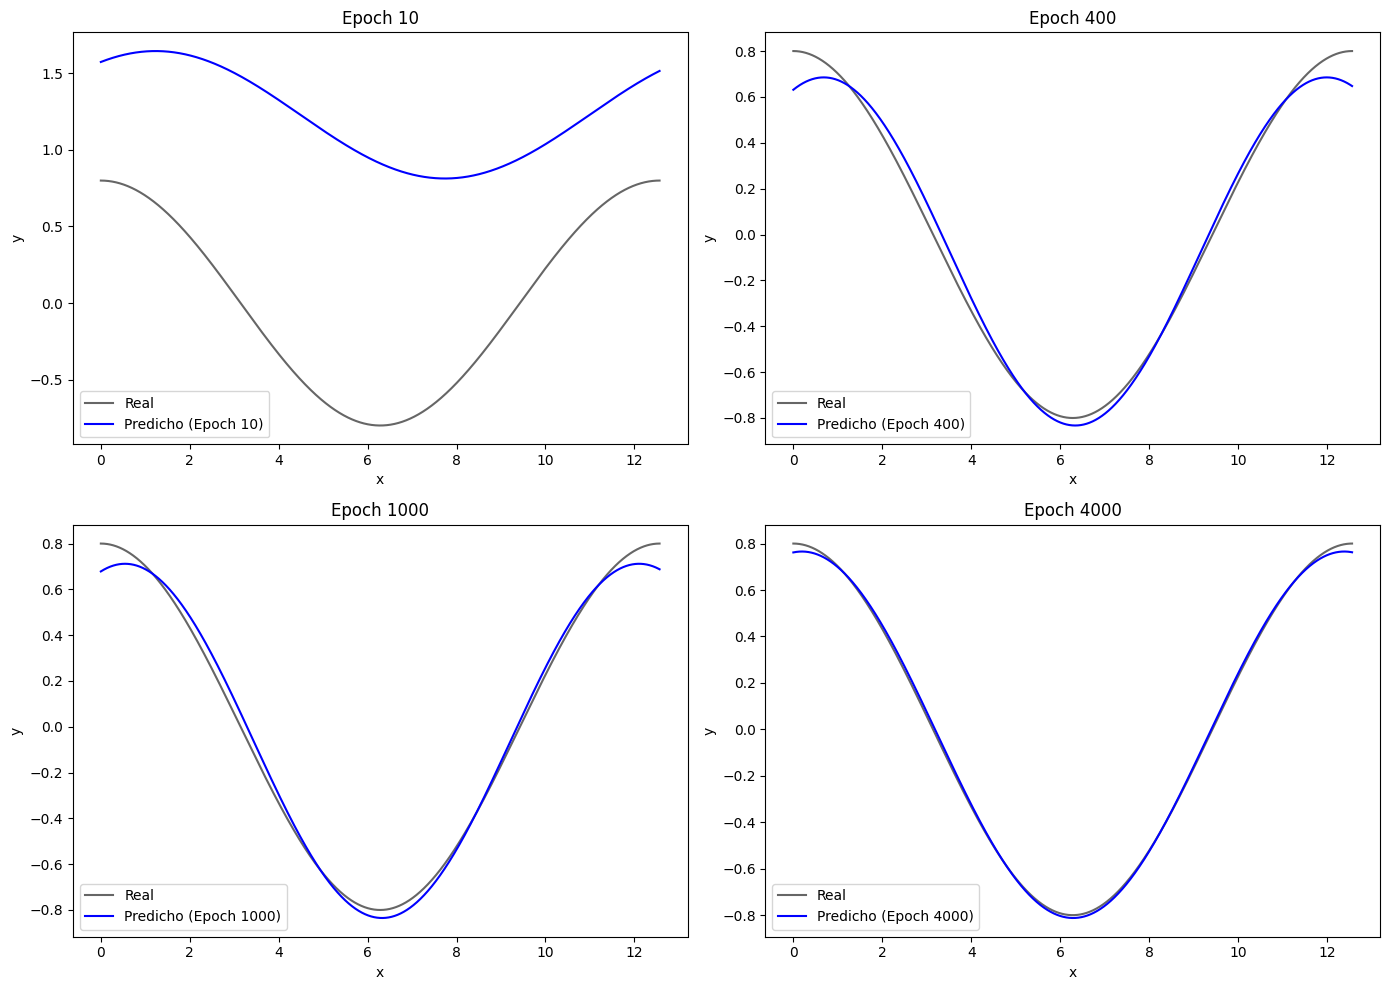

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sounddevice as sd
import scipy.io.wavfile as wavfile
from scipy.io.wavfile import write




train_df = pd.read_csv("descubrir-senal-sonido-2025/train.csv")
x_data = train_df['x'].values.astype(np.float32)
y_data = train_df['TARGET'].values.astype(np.float32)


np.random.seed(42)
a, b, c, d = np.random.randn(4)

learning_rate = 0.01
epochs = 4000
batch_size = 64
history = []

def predict(a, b, c, d, x):
    return a * np.cos(b * x + c) + d


for epoch in range(1, epochs + 1):
    indices = np.random.choice(len(x_data), batch_size, replace=False)
    x_batch = x_data[indices]
    y_batch = y_data[indices]
    
    y_pred = predict(a, b, c, d, x_batch)
    error = y_batch - y_pred


    da = -2 * np.mean(error * np.cos(b * x_batch + c))
    db =  2 * np.mean(error * a * np.sin(b * x_batch + c) * x_batch)
    dc =  2 * np.mean(error * a * np.sin(b * x_batch + c))
    dd = -2 * np.mean(error)


    a -= learning_rate * da
    b -= learning_rate * db
    c -= learning_rate * dc
    d -= learning_rate * dd


    if epoch in [10, 400, 1000, 4000]:
        y_full_pred = predict(a, b, c, d, x_data)
        history.append((epoch, a, b, c, d, y_full_pred))


fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.ravel()

for i, (epoch, a_val, b_val, c_val, d_val, y_pred_epoch) in enumerate(history):
    axs[i].plot(x_data, y_data, label='Real', color='black', alpha=0.6)
    axs[i].plot(x_data, y_pred_epoch, label=f'Predicho (Epoch {epoch})', color='blue')
    axs[i].set_title(f'Epoch {epoch}')
    axs[i].legend()
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')

plt.tight_layout()
plt.show()


x_long = np.arange(x_data.min(), 20 * math.pi, 0.001).astype(np.float32)
long_signal = predict(a, b, c, d, x_long)


normalized_signal = (long_signal - np.min(long_signal)) / (np.max(long_signal) - np.min(long_signal)) * 2 - 1
normalized_signal = normalized_signal.astype(np.float32)


sd.play(normalized_signal, samplerate=44100)


write("predicted_signal.wav", 44100, normalized_signal)


test_df = pd.read_csv("descubrir-senal-sonido-2025/test.csv")
x_test = test_df['x'].values.astype(np.float32)
y_test_pred = predict(a, b, c, d, x_test)


submission = pd.DataFrame({
    'example_id': test_df['example_id'],
    'TARGET': y_test_pred
})
submission.to_csv("submission.csv", index=False)


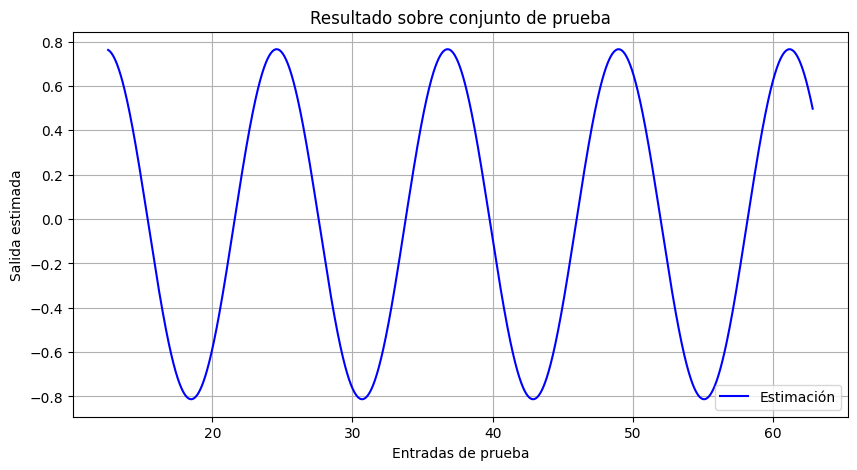

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(x_test, y_test_pred, label='Estimación', color='blue')
plt.xlabel('Entradas de prueba')
plt.ylabel('Salida estimada')
plt.title('Resultado sobre conjunto de prueba')
plt.legend()
plt.grid(True)
plt.show()

**Punto 2**


In [14]:
import pandas as pd
import re
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from collections import defaultdict


stopwords_nltk = stopwords.words('spanish')

def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r'[^\w\s]', '', text)  
    text = re.sub(r'\d+', '', text) 
    text = ' '.join(word for word in text.split() if word not in stopwords_nltk)
    return text


train_df_lstm = pd.read_csv("clasificar-texto-lstm-2025/train.csv")

train_df_lstm['texto'] = train_df_lstm['titulo'].astype(str).apply(preprocess_text)

def quitar_tildes(texto):
    texto_normalizado = unicodedata.normalize('NFKD', texto)
    texto_sin_tildes = ''.join([c for c in texto_normalizado if not unicodedata.combining(c)])
    return texto_sin_tildes

# Aplicar quitar tildes sobre la columna 'texto' ya preprocesada
train_df_lstm['texto'] = train_df_lstm['texto'].apply(quitar_tildes)

# Construir diccionario de palabras con su frecuencia total en todo el dataset
vocabulario = defaultdict(int)
palabras_por_titulo = []

for texto in train_df_lstm['texto']:
    palabras = texto.split()
    palabras_por_titulo.append(palabras)
    for palabra in palabras:
        vocabulario[palabra] += 1

print(f"Total de palabras únicas en el dataset: {len(vocabulario)}")

# Crear matriz de frecuencia palabra vs título
palabras_unicas = list(vocabulario.keys())
matriz_frecuencia = pd.DataFrame(0, index=range(len(train_df_lstm)), columns=palabras_unicas)

for i, palabras in enumerate(palabras_por_titulo):
    for palabra in palabras:
        matriz_frecuencia.at[i, palabra] += 1

# Mostrar algunas filas de la matriz para verificar
print(matriz_frecuencia.head())



Total de palabras únicas en el dataset: 1516
   sirven  triunfos  si  paz  corona  lapazhabla  mejores  formas  mostrar  \
0       1         1   1    1       1           1        0       0        0   
1       0         0   0    0       0           0        1       1        1   
2       0         0   0    0       0           0        0       0        0   
3       0         0   0    0       0           0        0       0        0   
4       0         0   0    0       0           0        0       0        0   

   forma  ...  magico  puso  opinas  machismo  cortaron  servicios  tranquilo  \
0      0  ...       0     0       0         0         0          0          0   
1      1  ...       0     0       0         0         0          0          0   
2      0  ...       0     0       0         0         0          0          0   
3      0  ...       0     0       0         0         0          0          0   
4      0  ...       0     0       0         0         0          0          0   


In [27]:
codificador = LabelEncoder()
etiquetas_codificadas = codificador.fit_transform(train_df_lstm["categoria"])
mapeo_etiquetas = dict(zip(codificador.classes_, codificador.transform(codificador.classes_)))
print(mapeo_etiquetas)

lista_textos = train_df_lstm["texto"].tolist()
tfidf_vect = TfidfVectorizer()
matriz_tfidf = tfidf_vect.fit_transform(lista_textos)
print("Dimensiones de la matriz TF-IDF:", matriz_tfidf.shape)


{'Deportes': 0, 'Educación': 1, 'Entretenimiento': 2, 'Gente y Blogs': 3, 'Otros': 4, 'Película y Animación': 5}
Dimensiones de la matriz TF-IDF: (800, 1507)


Metricas Regresion Logistica
                      precision    recall  f1-score   support

            Deportes       0.83      0.92      0.88        38
           Educación       0.75      0.25      0.38        24
     Entretenimiento       0.59      0.79      0.68        48
       Gente y Blogs       1.00      0.25      0.40         8
               Otros       1.00      0.20      0.33        10
Película y Animación       0.48      0.62      0.54        32

            accuracy                           0.64       160
           macro avg       0.78      0.51      0.53       160
        weighted avg       0.70      0.64      0.62       160



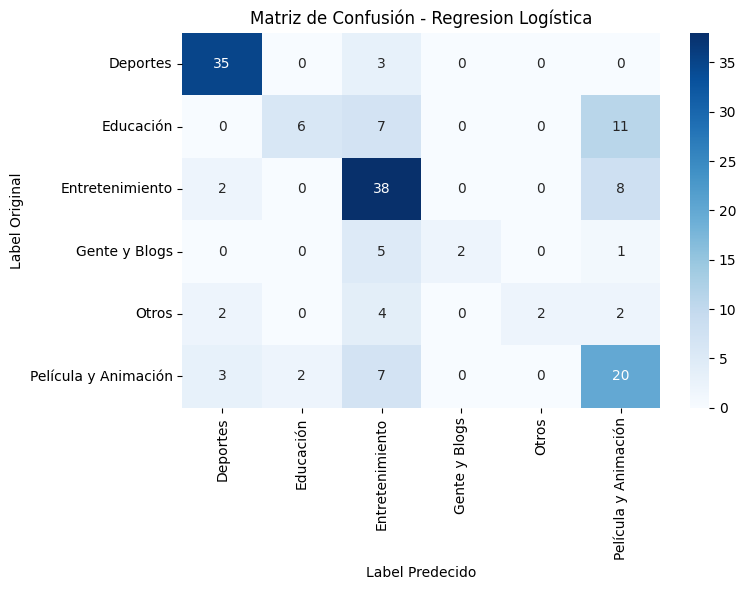

In [23]:
x_train, x_val, y_train, y_val = train_test_split(
    matriz_tfidf, etiquetas_codificadas, test_size=0.2, random_state=42
)

modelo1 = LogisticRegression(max_iter=1000)
modelo1.fit(x_train, y_train)

predicciones = modelo1.predict(x_val)


print("Metricas Regresion Logistica")
print(classification_report(y_val, predicciones, target_names=codificador.classes_))

matriz_confusion = confusion_matrix(y_val, predicciones)
plt.figure(figsize=(8, 6))
sns.heatmap(
    matriz_confusion,
    annot=True,
    fmt="d",
    xticklabels=codificador.classes_,
    yticklabels=codificador.classes_,
    cmap="Blues"
)
plt.xlabel("Label Predecido")
plt.ylabel("Label Original")
plt.title("Matriz de Confusión - Regresion Logística")
plt.tight_layout()
plt.show()

In [28]:
# Transformar el texto del conjunto de prueba con el mismo vectorizador usado (por ejemplo, TF-IDF)
test_tfidf = tfidf_vect.transform(test_df_lstm["texto"])  # Ajusta el nombre de la columna si es necesario

# Predecir con el modelo entrenado
categorias_predichas = modelo1.predict(test_tfidf)

# Crear DataFrame de resultados
resultados = pd.DataFrame({
    "ID": test_df_lstm["index"],  # Asegúrate de que test_df_lstm tenga una columna 'index'
    "categoria": codificador.inverse_transform(categorias_predichas)
})

# Guardar resultados en archivo CSV
resultados.to_csv("resultado_regresion_logisitica.csv", index=False, encoding='utf-8')


Metricas Random Forest:
                      precision    recall  f1-score   support

            Deportes       0.90      0.74      0.81        38
           Educación       0.54      0.29      0.38        24
     Entretenimiento       0.64      0.75      0.69        48
       Gente y Blogs       0.67      0.25      0.36         8
               Otros       0.75      0.60      0.67        10
Película y Animación       0.49      0.75      0.59        32

            accuracy                           0.64       160
           macro avg       0.67      0.56      0.58       160
        weighted avg       0.67      0.64      0.64       160



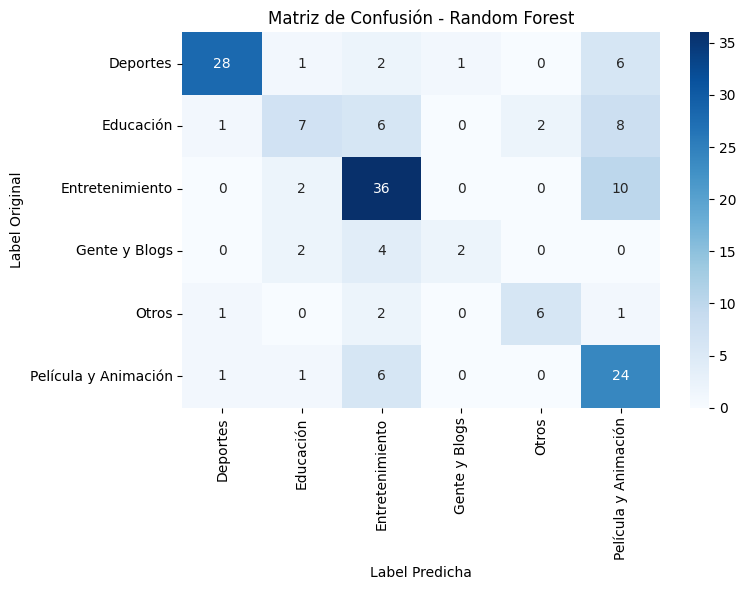

In [29]:
modelo2 = RandomForestClassifier(n_estimators=100, random_state=42)
modelo2.fit(x_train, y_train)

predicciones_modelo2 = modelo2.predict(x_val)

print("Metricas Random Forest:")
print(classification_report(y_val, predicciones_modelo2, target_names=codificador.classes_))

matriz_confusion_rf = confusion_matrix(y_val, predicciones_modelo2)
plt.figure(figsize=(8, 6))
sns.heatmap(
    matriz_confusion_rf,
    annot=True,
    fmt='d',
    xticklabels=codificador.classes_,
    yticklabels=codificador.classes_,
    cmap="Blues"
)
plt.xlabel("Label Predicha")
plt.ylabel("Label Original")
plt.title("Matriz de Confusión - Random Forest")
plt.tight_layout()
plt.show()

In [30]:

categorias_predichas_rf = modelo2.predict(test_tfidf)

resultados_rf = pd.DataFrame({
    "ID": test_df_lstm["index"],  
    "categoria": codificador.inverse_transform(categorias_predichas_rf)
})


resultados_rf.to_csv("resultado_random_forest.csv", index=False, encoding='utf-8')

In [18]:
texto_filtrado = train_df_lstm["texto"].tolist()

tokenizador = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizador.fit_on_texts(texto_filtrado)

secuencias_texto = tokenizador.texts_to_sequences(texto_filtrado)

longitud_maxima = max(len(sec) for sec in secuencias_texto)

X_padded = pad_sequences(secuencias_texto, maxlen=longitud_maxima, padding='post')

codificador_etiquetas = LabelEncoder()
y_codificado = codificador_etiquetas.fit_transform(train_df_lstm["categoria"])
cantidad_clases = len(codificador_etiquetas.classes_)

x_train, x_val, y_train, y_val = train_test_split(
    X_padded, y_codificado, test_size=0.2, random_state=42
)

y_train_onehot = to_categorical(y_train, num_classes=cantidad_clases)
y_val_onehot = to_categorical(y_val, num_classes=cantidad_clases)

In [19]:
red_neuronal = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=longitud_maxima),
    LSTM(units=64),
    Dense(units=cantidad_clases, activation='softmax')
])


red_neuronal.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


historial = red_neuronal.fit(
    x_train, 
    y_train_onehot, 
    validation_data=(x_val, y_val_onehot), 
    epochs=50, 
    batch_size=32
)
pérdida, precisión = red_neuronal.evaluate(x_val, y_val_onehot)
print(f"Precisión del modelo LSTM: {precisión:.2f}")

Epoch 1/50
20/20 [==============================] - 5s 81ms/step - loss: 1.7161 - accuracy: 0.2609 - val_loss: 1.6279 - val_accuracy: 0.3000
Epoch 2/50
20/20 [==============================] - 1s 39ms/step - loss: 1.6368 - accuracy: 0.2734 - val_loss: 1.5962 - val_accuracy: 0.3000
Epoch 3/50
20/20 [==============================] - 1s 28ms/step - loss: 1.5613 - accuracy: 0.2922 - val_loss: 1.5029 - val_accuracy: 0.3438
Epoch 4/50
20/20 [==============================] - 0s 23ms/step - loss: 1.2822 - accuracy: 0.5016 - val_loss: 1.3734 - val_accuracy: 0.4938
Epoch 5/50
20/20 [==============================] - 0s 25ms/step - loss: 0.8974 - accuracy: 0.6562 - val_loss: 1.2314 - val_accuracy: 0.6000
Epoch 6/50
20/20 [==============================] - 0s 17ms/step - loss: 0.5583 - accuracy: 0.8062 - val_loss: 1.2897 - val_accuracy: 0.6062
Epoch 7/50
20/20 [==============================] - 0s 17ms/step - loss: 0.3831 - accuracy: 0.9062 - val_loss: 1.3897 - val_accuracy: 0.5437
Epoch 8/50
20

In [10]:
test_df_lstm = pd.read_csv("clasificar-texto-lstm-2025/test.csv")

test_df_lstm['texto'] = test_df_lstm['titulo'].astype(str).apply(preprocess_text)

In [11]:

secuencias_prueba = tokenizador.texts_to_sequences(test_df_lstm["texto"])


x_test = pad_sequences(secuencias_prueba, maxlen=longitud_maxima, padding='post')


predicciones_prob = red_neuronal.predict(x_test)


clases_predichas = predicciones_prob.argmax(axis=1)


categorias_predichas = codificador_etiquetas.inverse_transform(clases_predichas)


resultados = pd.DataFrame({
    "ID": test_df_lstm["index"],           
    "categoria": categorias_predichas
})

# Guardar resultados en archivo CSV
resultados.to_csv("resultado_texto.csv", index=False, encoding='utf-8')

NameError: name 'tokenizador' is not defined